<a href="https://colab.research.google.com/github/kiyong21c/pytorch_tutorial/blob/main/20220713_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

['ants', 'bees']


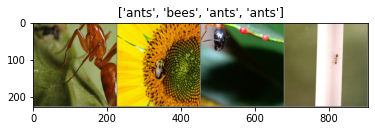

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.6961 Acc: 0.5984
val Loss: 0.4830 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.5215 Acc: 0.7664
val Loss: 0.3241 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4348 Acc: 0.8279
val Loss: 0.2633 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.3879 Acc: 0.8320
val Loss: 0.2268 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4108 Acc: 0.8197
val Loss: 0.2031 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3559 Acc: 0.8525
val Loss: 0.2125 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3961 Acc: 0.8443
val Loss: 0.1963 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3769 Acc: 0.8320
val Loss: 0.1957 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3170 Acc: 0.8689
val Loss: 0.2030 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3845 Acc: 0.8074
val Loss: 0.1905 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3897 Acc: 0.8279
val Loss: 0.1934 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3666 Acc: 0.8361
val Loss: 0.2028 Acc: 0.9216

Ep

In [ ]:
# transfer learning

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from zipfile import ZipFile

# train/value 이미지 데이터 압축 풀기 -> /content/
with ZipFile('/content/drive/MyDrive/Colab Notebooks/pytorch_tutorial/hymenoptera_data.zip') as zipper:
    zipper.extractall() # '/content/' 폴더에 압축풀림(default)


# mean : 평균,std : 표준편차,var : 분산
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

# 훈련/검증 데이터의 이미지처리방식을 Dict 형태로 정의
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std) # 정규화 : (X-mean)/std
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
# data_transforms['train'] : data_transforms 딕셔너리에서 'train'이라는 key의 value에 접근할 수 있음

data_dir = '/content/hymenoptera_data'

# Dictionary Comprehension 사용
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),    # .datasets.ImageFolder(폴더경로, transform=) : 폴더경로로 dataset형태를 만들어줌
                                          data_transforms[x])
                  for x in ['train', 'val']}
# ImageFolder를 통해 dataset 객체 생성시, 지정된 폴더 하부의 폴더명을 타깃값(레이블)로 지정하여 .classes로 접근가능

# image_datasets의 key/value를 dataloasers에서 다시 활용하기 위해 Dict Comprehension사용
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} # {'train': 244, 'val': 153}
class_names = image_datasets['train'].classes

image_datasets['train'] # ImageFolder 클래스로 생성된 데이터셋 인스턴스(객체)
image_datasets['train'].classes # ImageFolder 클래스로 생성된 데이터셋 인스턴스(객체)에서 classes로 하부 폴더명(타깃값)에 접근

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # ['ants', 'bees']


def imshow(inp, title):
    """Imshow for Tensor."""
    # ToTensor()로 텐서화된 이미지를 matplotlib에서 사용가능한 형태로 변경
    ## 1. numpy()
    ### 2. transpose((1, 2, 0))
    #### 3. std 곱하고 평균을 더하고
    ##### 4. 0~1사이 값으로 자르기
    # print(inp.shape) # torch.Size([3, 228, 906])
    inp = inp.numpy().transpose((1, 2, 0)) # (228, 906, 3)
    inp = std * inp + mean # 정규화되돌리기
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train'])) # 하나만 샘플로 보기위해
# inputs.shape : [4, 3, 224, 224]
# classes : [1, 0, 0, 1] # DataLoader 클래스를 통해 불러온 타깃값은 인덱스화 되어있음

# Make a grid from batch
out = torchvision.utils.make_grid(inputs) # batch(4개이미지)를 하나의 이미지로
# out.shape : [3, 228, 906]

imshow(out, title=[class_names[x] for x in classes])
# DataLoader를 통해 생성한 객체의 타깃값은 인덱스로 나타나 있음

def train_model(model, criterion, optimizer, scheduler, num_epochs=25): # scheduler : 다양한 종류의 learning_rate를 지정하며, epoch마다의 step이 점점 좁아지도록 함
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # deepcopy() : 원본에 영향을 주지않는 복제버전 생성
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에포크 마다 train(훈련) -> val(검증) 진행
        # Each epoch has a training and validation phase : train, val 단계 각각 다른 모드를 설정
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode (= model.train(False))

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): # set_grad_enabled(False) = no_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1) # 최대값, 인덱스
                    # preds : tensor([0, 1, 1, 0]) 

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0) # 손실값 x 배치크기(4)
                running_corrects += torch.sum(preds == labels.data) # 예측이 실제값과 맞는 개수
            
            if phase == 'train':
                scheduler.step() # 학습할 때 batch마다 optimizer.step() 하고 epoch마다 scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase] # 금번의 epoch에서 전체손실값/전체데이터크기
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # double() : tensor의 자료형 변환(64-bit floating point)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc: # 금번 에포크의 epoch_acc vs 직전 에포크에서 업데이트 된 best_acc
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    # 모든 에포크(25) 종료
    time_elapsed = time.time() - since # 소요된 시간
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts) # 모델에 최고의 가중치를 불러옴
    return model


#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.
# 이미 학습된 모델에 추가 데이터를 투입하여 파라미터를 업데이트하는 방법
# final fully connected layer만 수정하는 것은 사실 진정한 의미의 전이학습은 아님(가진데이터가 작기때문에 어쩔수 없음)

model = models.resnet18(pretrained=True) # resnet18의 경우 최종 layer가 fc 이고 입력이 512-d 출력이 1000-d
# models.resnet18() 함수내부에서 model.load_state_dict 이 수행되어 parameter가 copy된 모델이 return됨
num_ftrs = model.fc.in_features # fc.in_features : 입력 채널 수(=512)
# # Here the size of each output sample is set to 2. : 출력 채널 수(=2)
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)). : nn.Linear(입력512, 출력2) 
model.fc = nn.Linear(num_ftrs, 2) # model.fc로 기존 fc(512->1000) 변경가능(512->2)

model = model.to(device)

criterion = nn.CrossEntropyLoss() # 사용될 손실함수 정의

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# +++Learning rate scheduling should be applied after optimizer’s update+++
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#         for batch in dataloader
#         foward(...)
#         backward(...)
#             optimizer.step()  <----- 배치마다
#     scheduler.step()  <------ 에포크마다
#     validate(...)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # lr이 설정되어있는 optimizer를 파라미터로 받음
# optimizer에 설정된 lr(0.001)에 step_size(7epoch) 마다 gamma(0.1)를 곱해주는 방식

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


# #### ConvNet as fixed feature extractor ####
# # Here, we need to freeze all the network except the final layer.
# # We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
# model_conv = torchvision.models.resnet18(pretrained=True)
# for param in model_conv.parameters():
#     param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)

# model_conv = model_conv.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that only parameters of final layer are being optimized as
# # opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=25)